# Two relaxations for uncapacitated lot-sizing

<b>Goal:</b> Implement two relaxations for the uncapacitated lot-sizing problems and compare their performance.

In this notebook, we consider the formulations $(6.10)$ and $(7.3)$ for the uncapacitated lot-sizing problem from the script and their linear relaxations, which we denote by $Q_1$ and $Q_2$, respectively. We implement both relaxations using python-mip and compare their performance on a collection of concrete instances.

## Implementation

In [1]:
from mip import *

In [2]:
class UncapLotSizingInstance:
    def __init__(self, T, d, p, q, h):
        '''Initializes the class storing an instance of the uncapacitated lot-sizing problem.
        
        Args:
            T: Positive integer, number of time steps.
            d: List of non-negative reals, the demand vector.
            p: List of non-negative reals, the production cost vector.
            q: List of non-negative reals, the setup cost vector.
            h: List of non-negative reals, the storage cost vector.
        '''
        self.T, self.d, self.p, self.q, self.h = T, d, p, q, h
    
    def is_ok(self):
        '''Checks if the parameters of the instance satisfy the conditions described in the docstring in __init__().
        
        Returns:
            True or False indicating if the parameters of the instance are well-behaved.
        '''
        return (self.T > 0 and
                all(len(list_) == self.T and all(i >= 0 for i in list_)
                    for list_ in [self.d, self.p, self.q, self.h]))

In [ ]:
def q_1_relaxation(instance):
    '''Returns the Q_1 relaxation for an instance of the uncapacitated lot-sizing problem.
    
    Args:
        instance(UncapLotSizingInstance): The problem instance.
    
    Returns:
        A python-mip model encoding the Q_1 relaxation for the given instance.
    '''
    # Write your implementation here

    # minimize
    lp = Model(name = "Q1", sense=MINIMIZE)

    # define variables
    x = [lp.add_var(name=f"x_{t}", lb=0) for t in range(instance.T)]
    s = [lp.add_var(name=f"s_{t}", lb=0) for t in range(instance.T)]
    y = [lp.add_var(name=f"y_{t}", lb=0, ub=1) for t in range(instance.T)]

    # define M
    M = sum(instance.d)

    # add stock constraints
    lp += s[0] == x[0] - instance.d[0]
    for t in range(1, instance.T):
        lp += s[t] == s[t - 1] + x[t] - instance.d[t]
    
    # add big-M constraints
    for i in range(instance.T):
        lp += x[i] <= M * y[t]
    
    # define objective
    lp.objective = xsum([instance.p[t] * x[t] for t in range(instance.T)]) + xsum([instance.h[t] * s[t] for t in range(instance.T)]) + xsum([instance.q[t] * y[t] for t in range(instance.T)])

    return lp

In [4]:
def q_2_relaxation(instance):
    '''Returns the Q_2 relaxation for an instance of the uncapacitated lot-sizing problem.
    
    Args:
        instance(UncapLotSizingInstance): The problem instance.
    
    Returns:
        A python-mip model encoding the Q_2 relaxation for the given instance.
    '''
    # Write your implementation here

    # minimize
    lp = Model(name = "Q1", sense=MINIMIZE)

    # define variables
    x = [lp.add_var(name=f"x_{t}", lb=0) for t in range(instance.T)]
    s = [lp.add_var(name=f"s_{t}", lb=0) for t in range(instance.T)]
    y = [lp.add_var(name=f"y_{t}", lb=0, ub=1) for t in range(instance.T)]

    Z = [(t, l) for t in range(instance.T) for l in range(t, instance.T)]
    z = {(t, l) : lp.add_var(name=f"z_{t},{l}", lb=0, ub=1) for (t, l) in Z}

    # add stock constraints
    lp += s[0] == x[0] - instance.d[0]
    for t in range(1, instance.T):
        lp += s[t] == s[t - 1] + x[t] - instance.d[t]
    
    for (t, l) in Z:
        lp += z[t, l] <= y[t]

    for t in range(instance.T):
        lp += x[t] == xsum([instance.d[l] * z[t, l] for l in range(t, instance.T)])

    for l in range(instance.T):
        lp += xsum([z[t, l] for t in range(l + 1)]) == 1
    
    # define objective
    lp.objective = xsum([instance.p[t] * x[t] for t in range(instance.T)]) + xsum([instance.h[t] * s[t] for t in range(instance.T)]) + xsum([instance.q[t] * y[t] for t in range(instance.T)])

    return lp

## Testing

Test your implementation by running the code below. Answer the following questions:
1. What is the number of variables and constraints used in each of the two relaxations?
1. Which relaxation is solved faster on average?

<i>Note:</i> The measurements take a few minutes to complete. Feel free to change the measurement range and the number of repetitions, but make sure the difference in performance remains clear.

In [6]:
import matplotlib.pyplot as plt
import random
import time

In [7]:
def random_array(a_len, a_min, a_max):
    '''Returns an array of length a_len filled with random elements between a_min and a_max.'''
    return [random.uniform(a_min, a_max) for i in range(a_len)]


def random_instance(T):
    '''Generates a random instance of the uncapacitated lot-sizing problem with T time steps.'''
    d = random_array(T, 0, 100)
    p = random_array(T, 400, 420)
    q = random_array(T, 1000, 2000)
    h = random_array(T, 10, 20)
    return UncapLotSizingInstance(T, d, p, q, h)

In [ ]:
# Initialize measurements
num_reps = 5
T_range = range(10, 261, 25)
times = [{T: [] for T in T_range}, {T: [] for T in T_range}]
relaxations = [q_1_relaxation, q_2_relaxation]
relaxation_names = ['Q_1 Relaxation', 'Q_2 Relaxation']
random.seed(1)

for T in T_range:
    print(f'Measuring for T = {T}...')
    
    for rep in range(num_reps):
        print(f'Repetition {rep}...')
        
        # Generate a random instance
        instance = random_instance(T)
        
        for i in range(2):
            # Measure the performance of the i-th model on the generated instance
            m = relaxations[i](instance)
            start = time.process_time()
            m.optimize()
            end = time.process_time()
            dt = end - start
            times[i][T].append(dt)
            print(f'{relaxation_names[i]} has optimal value {m.objective_value}, found in time {dt}.')

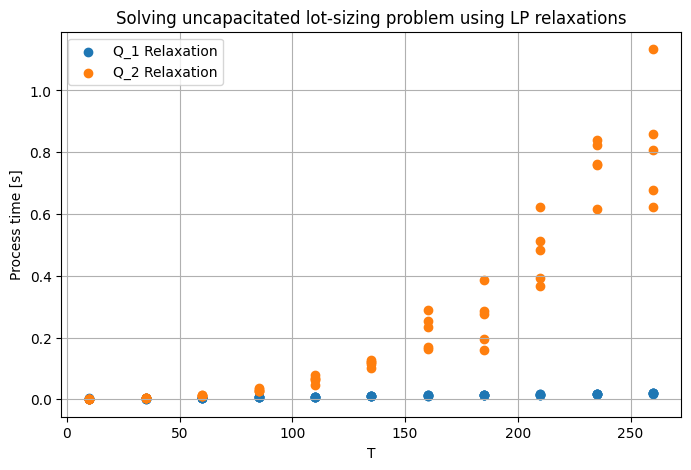

In [10]:
# Plot the measurement results
plt.figure(figsize=(8,5))
plt.title('Solving uncapacitated lot-sizing problem using LP relaxations')
plt.xlabel('T')
plt.ylabel('Process time [s]')
for i in range(2):
    plt.scatter([size for size, res in times[i].items() for time in res if time <= 10], 
                [time for size, res in times[i].items() for time in res if time <= 10],
                label=relaxation_names[i])
plt.legend()
plt.grid(True)
plt.show()

## (Optional) Verification of the example for part (a)

Let us numerically verify that the example we proposed in part (a) is correct. To this end, we construct the corresponding problem instance, create the two relaxations using `q_1_relaxation()` and `q_2_relaxation()`, and solve the models. As we can see, the optimal values differ by exactly a factor of $2$, so our example instance is valid.

In [13]:
# Write your implementation here
T = 3
d = [1, 1, 1]
p = [1, 1, 1]
q = [9, 9, 9]
h = [0, 0, 0]

inst = UncapLotSizingInstance(T, d, p, q, h)
q1_rel = q_1_relaxation(inst)
q2_rel = q_2_relaxation(inst)

q1_rel.optimize()
print(f"Q1 relaxation has optimal value: {q1_rel.objective_value}.")

q2_rel.optimize()
print(f"Q2 relaxation has optimal value: {q2_rel.objective_value}.")

Starting solution of the Linear programming problem using Primal Simplex

Coin0506I Presolve 5 (-1) rows, 5 (-4) columns and 11 (-3) elements
Clp1000I sum of infeasibilities 1.30112e-08 - average 2.60224e-09, 0 fixed columns
Coin0506I Presolve 5 (0) rows, 5 (0) columns and 11 (0) elements
Clp0006I 0  Obj 6.000173 Dual inf 797.1019 (4)
Clp0029I End of values pass after 5 iterations
Clp0000I Optimal - objective value 6
Clp0000I Optimal - objective value 6
Clp0000I Optimal - objective value 6
Coin0511I After Postsolve, objective 6, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 6 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00
Q1 relaxation has optimal value: 5.999999999999999.
Starting solution of the Linear programming problem using Dual Simplex

Coin0506I Presolve 4 (-11) rows, 5 (-10) columns and 10 (-25) elements
Clp0006I 0  Obj 11 Primal inf 1.999998 (2)
Clp0000I Optimal - objective value 12
Coin0511I After Postsolve, objective 12, infeasibilities - dual 